In [38]:
from __future__ import annotations

import pickle

import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from edpyt.dmft import DMFT, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from edpyt.nano_dmft import Gfloc
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.block_tridiag import greenfunction
from qtpyt.projector import ProjectedGreenFunction, expand
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})


In [39]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, outputfile, npsin):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(outputfile, sigma)

    for spin in range(nspin):
        save(spin)

def plot_atomic_positions_with_occupancy(atoms, element_colors, occupancy,title):

    fig, ax = plt.subplots(figsize=(10, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    occupancy_index = 0
    for i, (xi, yi, atom) in enumerate(zip(x, y, atoms)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


        if atom.symbol in ['C', 'N']:
            ax.text(
                xi + 0.2, yi,
                f"{occupancy[occupancy_index]:.2f}",
                color='blue', fontsize=9, ha='left', va='center'
            )
            occupancy_index += 1

    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title(title)

    plt.show()


In [40]:
def plot(gf, sigma_func, semilogy=True, reference_gf=None, label_ref="DFT"):
    """Plot the Green's function DOS and Tr(Sigma) with an optional reference DOS."""

    fig, axes = plt.subplots(2, 1, sharex=True)
    ax1, ax2 = axes

    w = z_ret.real
    dos = -1 / np.pi * gf(z_ret).sum(0).imag
    if semilogy:
        ax1.semilogy(w, dos, label="DMFT") if dos.ndim == 1 else ax1.semilogy(
            w, dos[0], label=r"spin $\uparrow$"
        )
    else:
        ax1.plot(w, dos, label="DMFT") if dos.ndim == 1 else ax1.plot(
            w, dos[0], label=r"spin $\uparrow$"
        )

    if reference_gf is not None:
        reference_dos = -1 / np.pi * reference_gf(z_ret).sum(0).imag
        ax1.plot(
            w, reference_dos, linestyle="--", label=label_ref
        ) if reference_dos.ndim == 1 else ax1.plot(
            w,
            reference_dos[0],
            linestyle="--",
            label=label_ref,
        )

    ax1.set_ylabel("DOS [a.u.]")
    ax1.legend(loc="upper right")

    ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    sigma = sigma_func(z_ret)
    trace_sigma = sigma.sum(axis=0)
    ax2.plot(w, trace_sigma.real, label="Re Tr(Sigma)", color="blue")
    ax2.plot(w, trace_sigma.imag, label="Im Tr(Sigma)", color="orange")

    ax2.set_xlabel("E-E$_F$ [eV]")
    ax2.set_ylabel("Tr(Sigma) [eV]")
    ax2.legend(loc="upper right")

    plt.subplots_adjust(hspace=0)
    return ax1


def callback(*args, **kwargs):
    # gfloc.Hybrid = HybRet
    _ = plot(
        gf=gfloc_with_dccorrection,
        sigma_func=gfloc_with_dccorrection.Sigma,
        reference_gf=gfloc_no_dccorrection,
        label_ref="DFT",
        semilogy=kwargs.get("semilogy", True),
    )
    # gfloc.Hybrid = HybRet
    plt.xlim(-2, 2)
    plt.show()
    plt.close()

In [41]:
atoms = read('dft/device/scatt.xyz')
filtered_atoms = atoms[[atom.symbol not in ['H', 'Au'] for atom in atoms]]
element_colors = {'C': 'cyan', 'N': 'green'}

In [42]:
data_folder = "output/lowdin"
occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
dft_dos = np.load(f"{data_folder}/dft_dos.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy",allow_pickle=True)

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
	hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
	hs_list_ij = pickle.load(f)

nbaths = 4
U = 4.0
tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
len_active = occupancy_goal.size
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 5e-3
z_ret = energies + 1.j * eta
beta = 1000
adjust_mu = True
use_double_counting = True

In [43]:
# Green's Function Setup
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
    mu=1e-3,
    kt=1 / beta,
)
gfp = ProjectedGreenFunction(gf, index_active_region)

In [44]:
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

hyb_ret = np.fromfile(f"{data_folder}/hybridization.bin", complex).reshape(
    z_ret.size,
    len_active,
    len_active,
)
_HybRet = interp1d(z_ret.real, hyb_ret, axis=0, bounds_error=False, fill_value=0.0)
HybRet = lambda z: _HybRet(z.real)

# HybMats = lambda z: 0.0
# HybRet = lambda z: 0.0

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.eye(len_active) * U

# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)
gfloc_with_dccorrection = Gfloc(
    H_active - double_counting,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)

nimp = gfloc_with_dccorrection.idx_neq.size
gfimp = [Gfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

In [45]:
Sigma = lambda z: np.zeros((nimp, z.size), complex)

In [46]:
gfloc_no_dccorrection = Gfloc(H_active ,S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta)
gfloc_no_dccorrection.update(mu=1e-3)
gfloc_no_dccorrection.set_local(Sigma)
dos = -1 / np.pi * gfloc_no_dccorrection(z_ret).sum(0).imag
x, peaks = find_peaks(dos, height=5)
z_ret[x]

array([0.+0.005j])

In [47]:
# Initialize DMFT with adjust_mu parameter
dmft = DMFT(
    gfimp,
    gfloc_with_dccorrection,
    occupancy_goal,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=adjust_mu,
    alpha=alpha,
    DC=double_counting,
)

In [48]:
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=1e-3)
delta_prev = delta.copy()
dmft.delta = delta

Iteration :  0
Occupation : 10.78730 Chemical potential : -0.11399 Error : 522.22652821 Relative Error : 0.99652264
Iteration :  1
Occupation : 10.78730 Chemical potential : -0.13442 Error : 244.34276953 Relative Error : 0.46672755


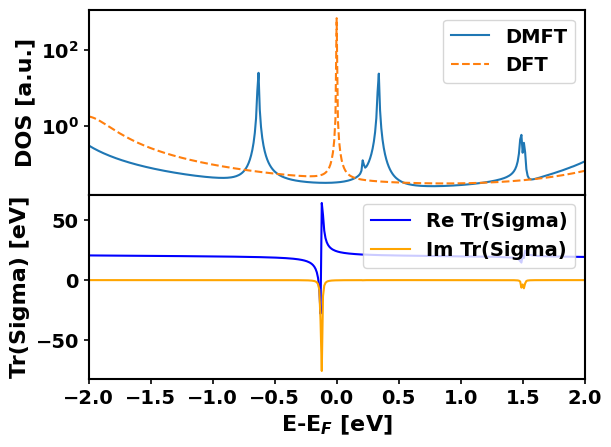

0:  |F(x)| = 31.6043; step 1
Iteration :  2
Occupation : 10.78730 Chemical potential : 0.03276 Error : 198.29534915 Relative Error : 0.37854029


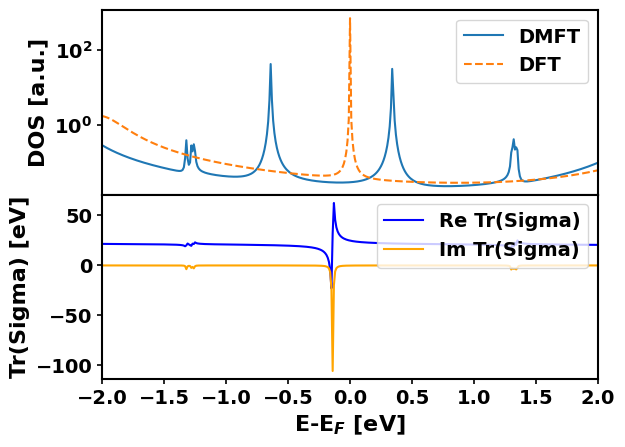

1:  |F(x)| = 26.7546; step 1
Iteration :  3
Occupation : 10.78730 Chemical potential : 0.07431 Error : 99.38762953 Relative Error : 0.15634694


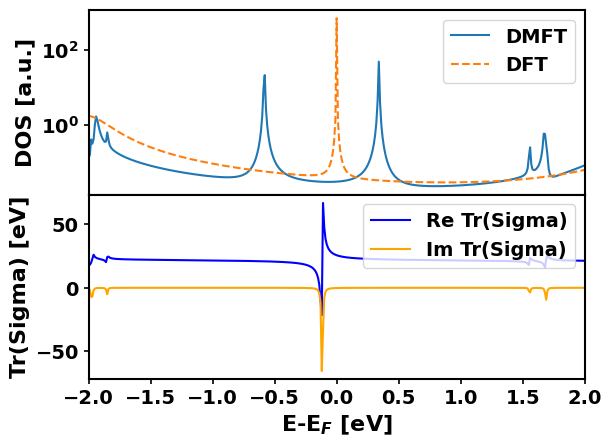

2:  |F(x)| = 16.9403; step 1
Iteration :  4
Occupation : 10.78730 Chemical potential : 0.09093 Error : 22.62758046 Relative Error : 0.03373554


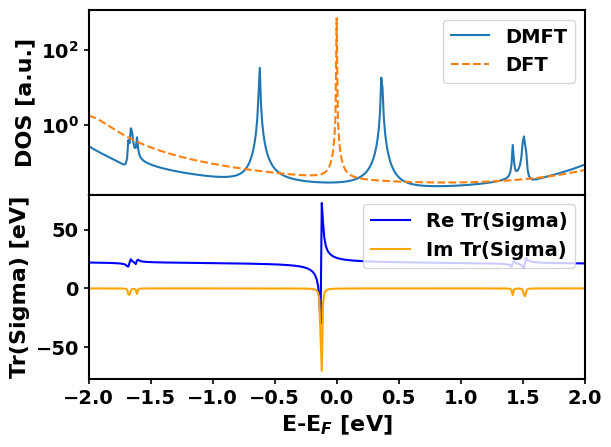

3:  |F(x)| = 3.34141; step 1
Iteration :  5
Occupation : 10.78730 Chemical potential : 0.09651 Error : 17.62837393 Relative Error : 0.02671262


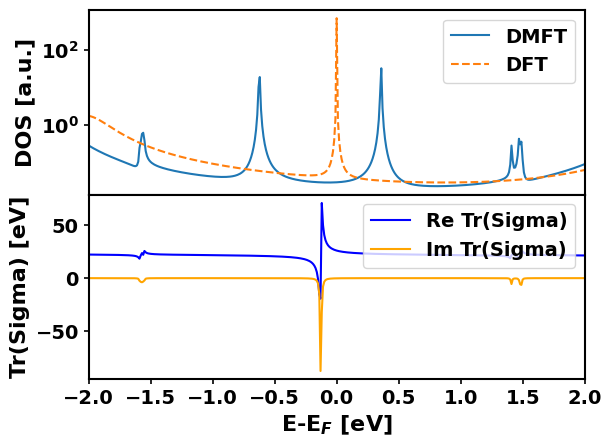

4:  |F(x)| = 2.37565; step 1
Iteration :  6
Occupation : 10.78730 Chemical potential : 0.10170 Error : 19.94183615 Relative Error : 0.03024623
Iteration :  7
Occupation : 10.78730 Chemical potential : 0.10433 Error : 24.48768735 Relative Error : 0.03712320
Iteration :  8
Occupation : 10.78730 Chemical potential : 0.10553 Error : 28.27111038 Relative Error : 0.04284191
Iteration :  9
Occupation : 10.78730 Chemical potential : 0.10629 Error : 29.47284503 Relative Error : 0.04466113
Iteration : 10
Occupation : 10.78730 Chemical potential : 0.10680 Error : 30.12030655 Relative Error : 0.04564198
Iteration : 11
Occupation : 10.78730 Chemical potential : 0.10704 Error : 30.29223646 Relative Error : 0.04590245
Iteration : 12
Occupation : 10.78730 Chemical potential : 0.10720 Error : 30.48088472 Relative Error : 0.04618829
Iteration : 13
Occupation : 10.78730 Chemical potential : 0.10730 Error : 30.60499929 Relative Error : 0.04637636
Iteration : 14
Occupation : 10.78730 Chemical potential : 0

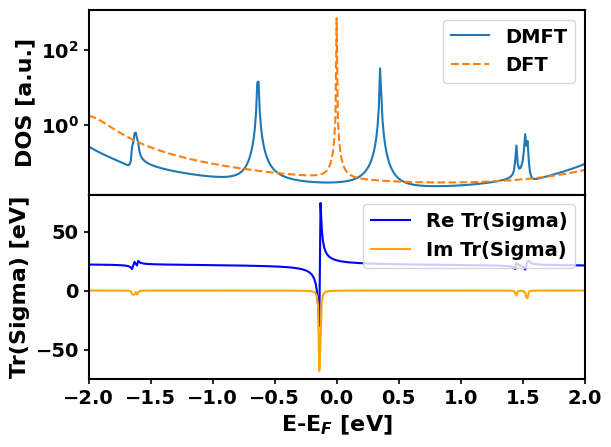

5:  |F(x)| = 3.57971; step 1
Iteration : 15
Occupation : 10.78730 Chemical potential : 0.11113 Error : 32.45300320 Relative Error : 0.05008435
Iteration : 16
Occupation : 10.78730 Chemical potential : 0.11184 Error : 28.93219958 Relative Error : 0.04417148
Iteration : 17
Occupation : 10.78730 Chemical potential : 0.11199 Error : 30.27562208 Relative Error : 0.04602880
Iteration : 18
Occupation : 10.78730 Chemical potential : 0.11197 Error : 31.20061875 Relative Error : 0.04734905
Iteration : 19
Occupation : 10.78730 Chemical potential : 0.11191 Error : 31.39367651 Relative Error : 0.04762196
Iteration : 20
Occupation : 10.78730 Chemical potential : 0.11186 Error : 31.37152612 Relative Error : 0.04758363
Iteration : 21
Occupation : 10.78730 Chemical potential : 0.11182 Error : 31.35003044 Relative Error : 0.04754976
Iteration : 22
Occupation : 10.78730 Chemical potential : 0.11180 Error : 31.32987348 Relative Error : 0.04751884
Iteration : 23
Occupation : 10.78730 Chemical potential : 0

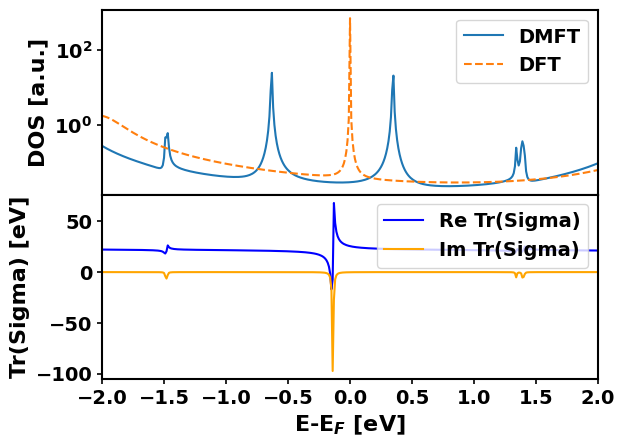

6:  |F(x)| = 5.29138; step 1
Iteration : 24
Occupation : 10.78730 Chemical potential : 0.11710 Error : 22.75391812 Relative Error : 0.03548674


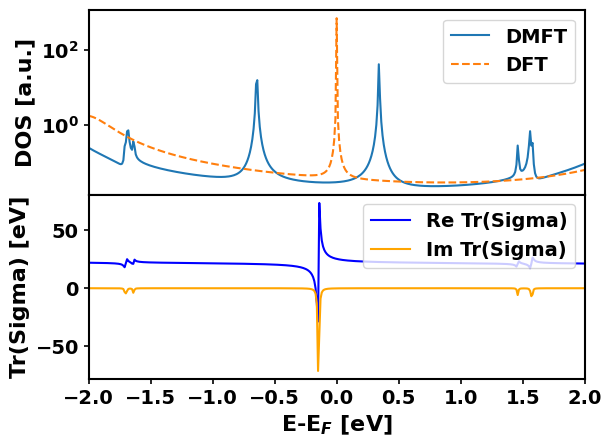

7:  |F(x)| = 3.03192; step 1
Iteration : 25
Occupation : 10.78730 Chemical potential : 0.12311 Error : 20.82122646 Relative Error : 0.03347828


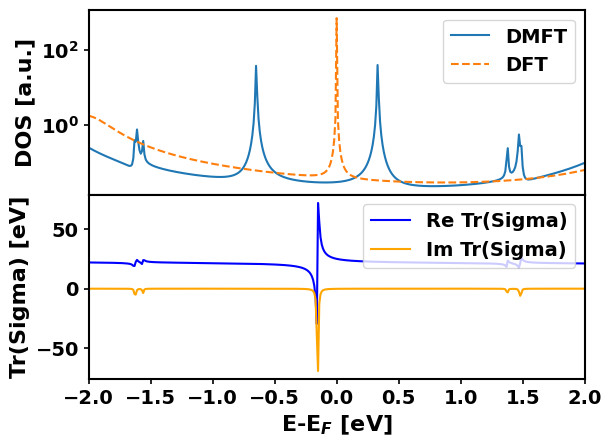

8:  |F(x)| = 2.80449; step 1
Iteration : 26
Occupation : 10.78730 Chemical potential : 0.12856 Error : 20.81881567 Relative Error : 0.03328756


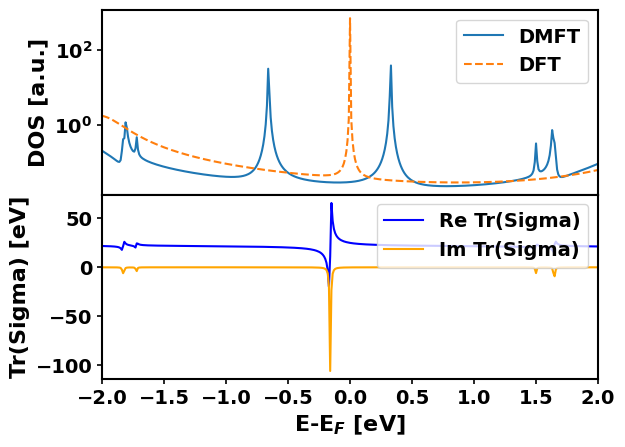

9:  |F(x)| = 2.5951; step 1
Iteration : 27
Occupation : 10.78730 Chemical potential : 0.13414 Error : 15.03930470 Relative Error : 0.02451429


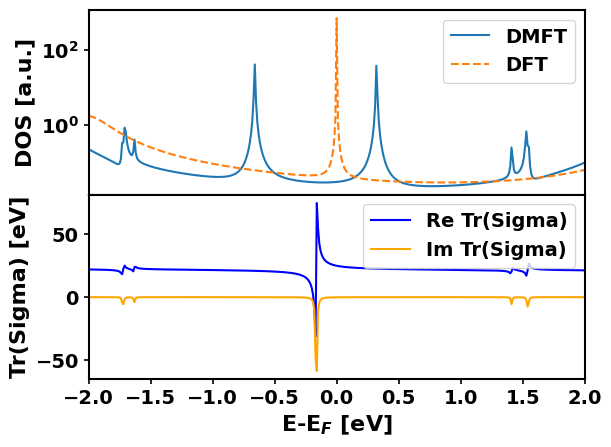

10:  |F(x)| = 1.88308; step 1
Iteration : 28
Occupation : 10.78730 Chemical potential : 0.13963 Error : 14.74190269 Relative Error : 0.02416007


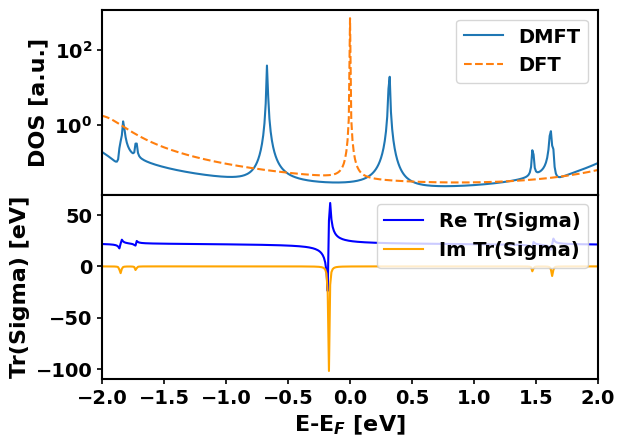

11:  |F(x)| = 1.81606; step 1
Iteration : 29
Occupation : 10.78730 Chemical potential : 0.14504 Error : 16.42176717 Relative Error : 0.02735128
Iteration : 30
Occupation : 10.78730 Chemical potential : 0.14765 Error : 17.62885123 Relative Error : 0.02908201
Iteration : 31
Occupation : 10.78730 Chemical potential : 0.14873 Error : 21.27445211 Relative Error : 0.03490660
Iteration : 32
Occupation : 10.78730 Chemical potential : 0.14931 Error : 22.40851392 Relative Error : 0.03673000
Iteration : 33
Occupation : 10.78730 Chemical potential : 0.14970 Error : 22.80469528 Relative Error : 0.03737520
Iteration : 34
Occupation : 10.78730 Chemical potential : 0.14995 Error : 23.02854714 Relative Error : 0.03774112
Iteration : 35
Occupation : 10.78730 Chemical potential : 0.15012 Error : 23.16669636 Relative Error : 0.03796729
Iteration : 36
Occupation : 10.78730 Chemical potential : 0.15023 Error : 23.25646969 Relative Error : 0.03811436
Iteration : 37
Occupation : 10.78730 Chemical potential : 

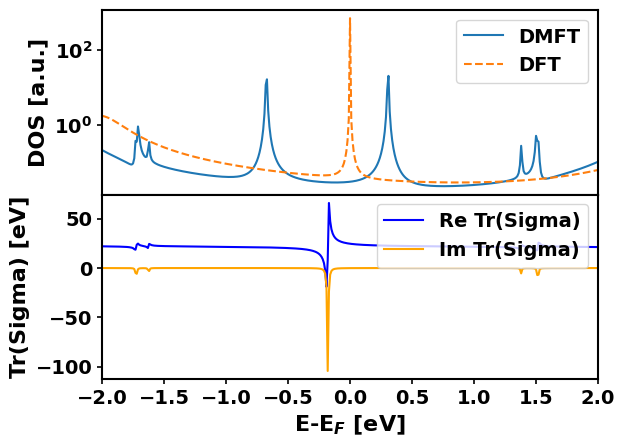

12:  |F(x)| = 2.58573; step 1
Iteration : 38
Occupation : 10.78730 Chemical potential : 0.15451 Error : 19.67470037 Relative Error : 0.03268188


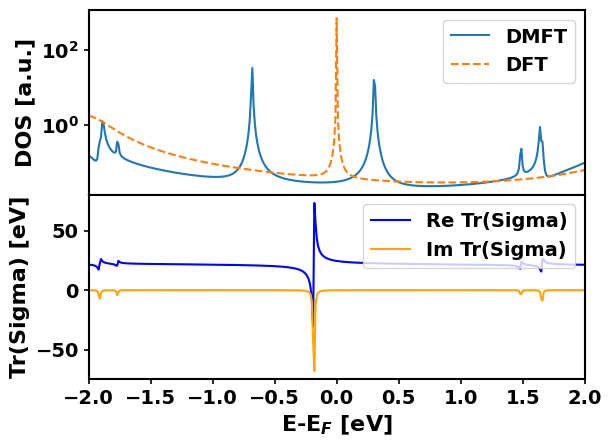

13:  |F(x)| = 2.37975; step 1
Iteration : 39
Occupation : 10.78730 Chemical potential : 0.15878 Error : 13.37996560 Relative Error : 0.02269726


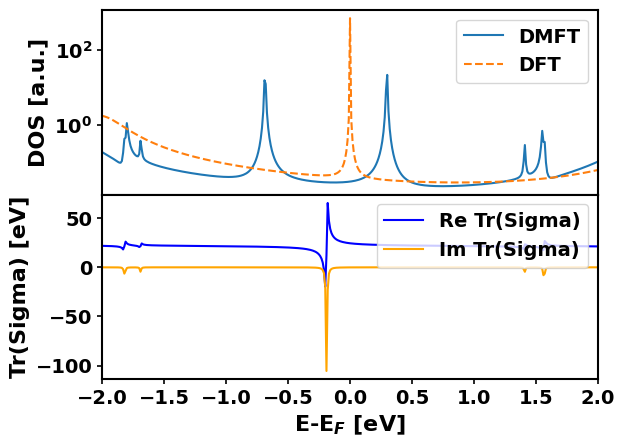

14:  |F(x)| = 1.69875; step 1
Iteration : 40
Occupation : 10.78730 Chemical potential : 0.16405 Error : 12.71044334 Relative Error : 0.02166288


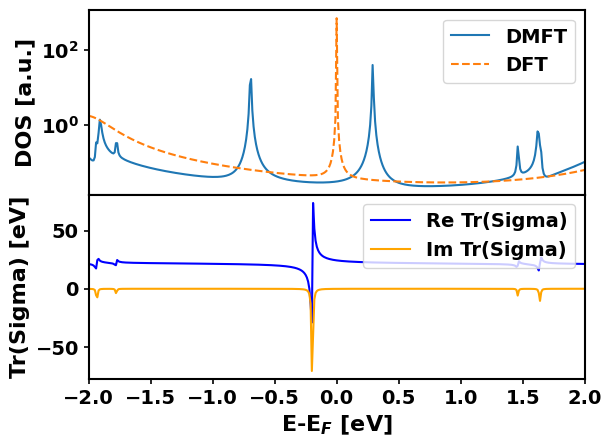

15:  |F(x)| = 1.53452; step 1
Iteration : 41
Occupation : 10.78730 Chemical potential : 0.16945 Error : 12.63700496 Relative Error : 0.02183519


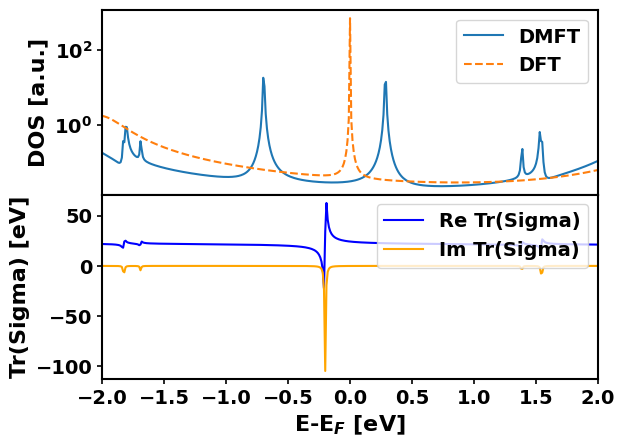

16:  |F(x)| = 1.55764; step 1
Iteration : 42
Occupation : 10.78730 Chemical potential : 0.17423 Error : 10.84320879 Relative Error : 0.01875673


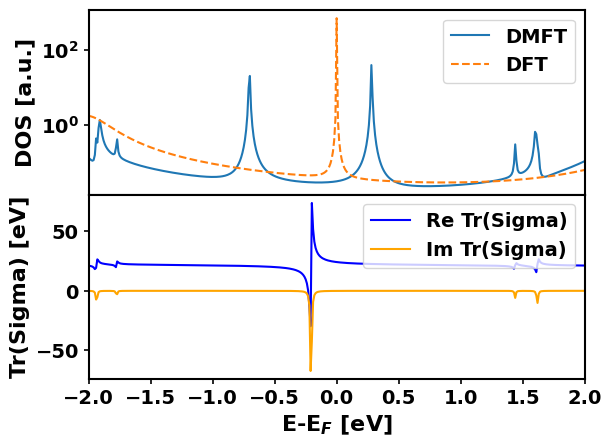

17:  |F(x)| = 1.30973; step 1
Iteration : 43
Occupation : 10.78730 Chemical potential : 0.17940 Error : 10.67983177 Relative Error : 0.01870109


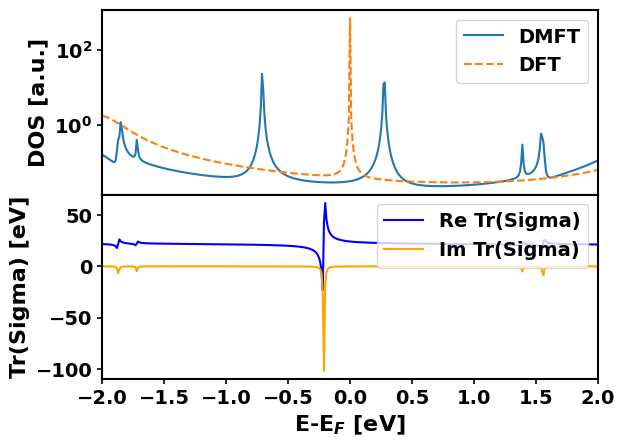

18:  |F(x)| = 1.31013; step 1
Iteration : 44
Occupation : 10.78730 Chemical potential : 0.18405 Error : 11.59931604 Relative Error : 0.02031153
Iteration : 45
Occupation : 10.78730 Chemical potential : 0.18653 Error : 12.60448986 Relative Error : 0.02207302
Iteration : 46
Occupation : 10.78730 Chemical potential : 0.18763 Error : 14.64371218 Relative Error : 0.02564268
Iteration : 47
Occupation : 10.78730 Chemical potential : 0.18827 Error : 15.40075363 Relative Error : 0.02696783
Iteration : 48
Occupation : 10.78730 Chemical potential : 0.18870 Error : 15.69858702 Relative Error : 0.02748929
Iteration : 49
Occupation : 10.78730 Chemical potential : 0.18898 Error : 15.87313329 Relative Error : 0.02779491
Iteration : 50
Occupation : 10.78730 Chemical potential : 0.18916 Error : 15.98270109 Relative Error : 0.02798677
Iteration : 51
Occupation : 10.78730 Chemical potential : 0.18929 Error : 16.05387679 Relative Error : 0.02811140
Iteration : 52
Occupation : 10.78730 Chemical potential : 

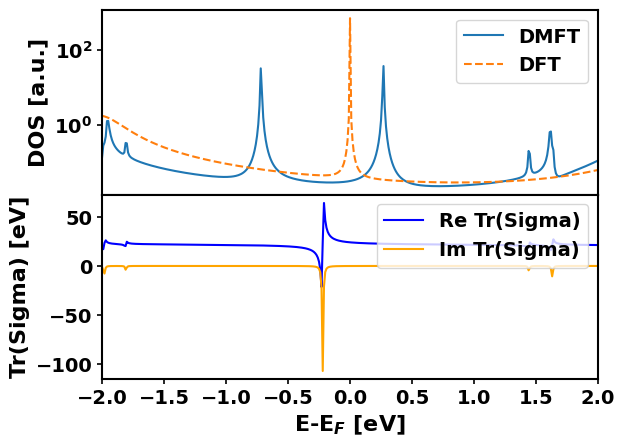

19:  |F(x)| = 1.81503; step 1
Iteration : 53
Occupation : 10.78730 Chemical potential : 0.19282 Error : 13.94543851 Relative Error : 0.02470212


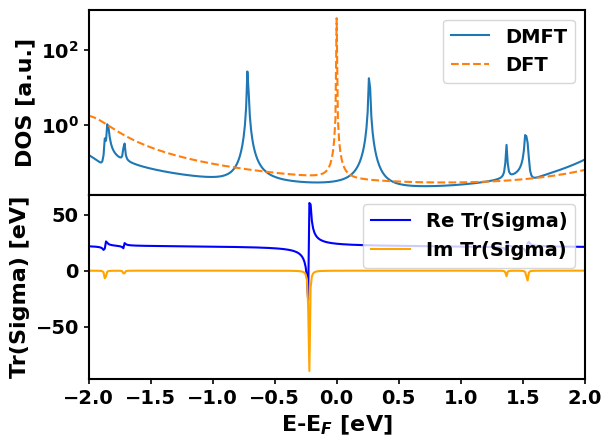

20:  |F(x)| = 1.6619; step 1
Iteration : 54
Occupation : 10.78730 Chemical potential : 0.19654 Error : 9.79219780 Relative Error : 0.01745113


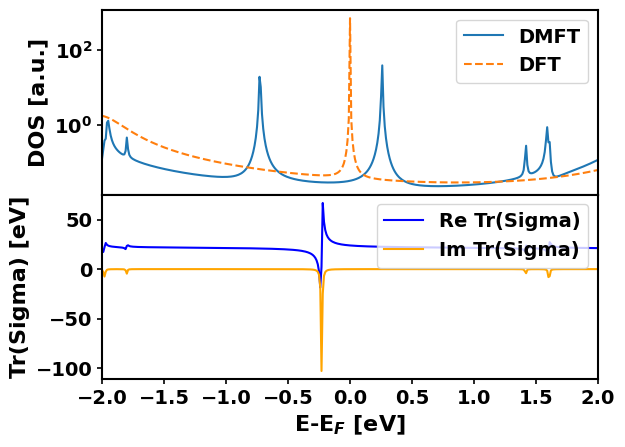

21:  |F(x)| = 1.18266; step 1
Iteration : 55
Occupation : 10.78730 Chemical potential : 0.20222 Error : 10.18318893 Relative Error : 0.01840268
Iteration : 56
Occupation : 10.78730 Chemical potential : 0.20421 Error : 11.33274579 Relative Error : 0.02032772
Iteration : 57
Occupation : 10.78730 Chemical potential : 0.20445 Error : 13.69553976 Relative Error : 0.02443948
Iteration : 58
Occupation : 10.78730 Chemical potential : 0.20432 Error : 14.20099120 Relative Error : 0.02531278
Iteration : 59
Occupation : 10.78730 Chemical potential : 0.20422 Error : 14.22893021 Relative Error : 0.02535917
Iteration : 60
Occupation : 10.78730 Chemical potential : 0.20415 Error : 14.21400914 Relative Error : 0.02533174
Iteration : 61
Occupation : 10.78730 Chemical potential : 0.20410 Error : 14.19486036 Relative Error : 0.02529739
Iteration : 62
Occupation : 10.78730 Chemical potential : 0.20407 Error : 14.17860119 Relative Error : 0.02526836
Iteration : 63
Occupation : 10.78730 Chemical potential : 

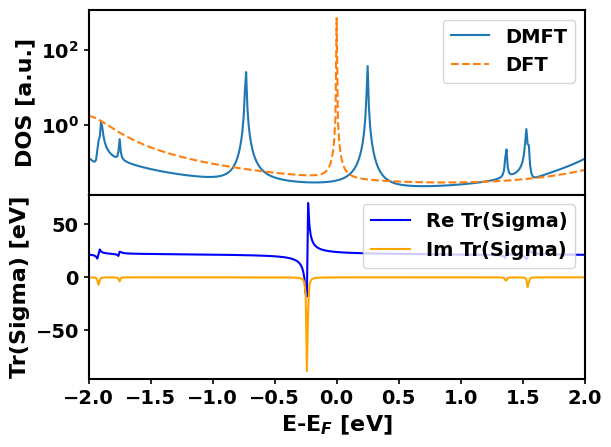

22:  |F(x)| = 1.45758; step 1
Iteration : 64
Occupation : 10.78730 Chemical potential : 0.20946 Error : 14.82425925 Relative Error : 0.02663597
Iteration : 65
Occupation : 10.78730 Chemical potential : 0.21086 Error : 11.73825660 Relative Error : 0.02117539


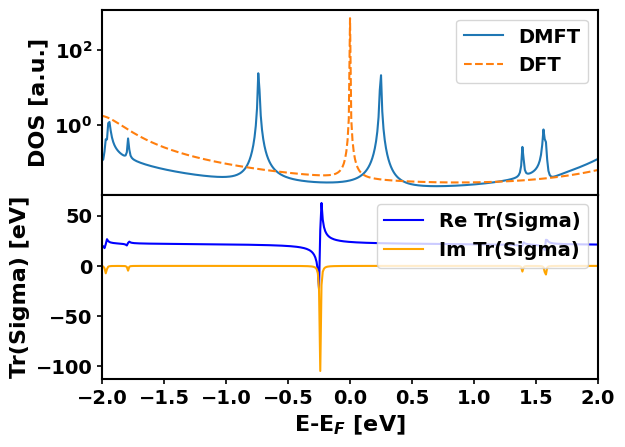

23:  |F(x)| = 1.40593; step 0.325722
Iteration : 66
Occupation : 10.78730 Chemical potential : 0.21446 Error : 9.91193467 Relative Error : 0.01809581


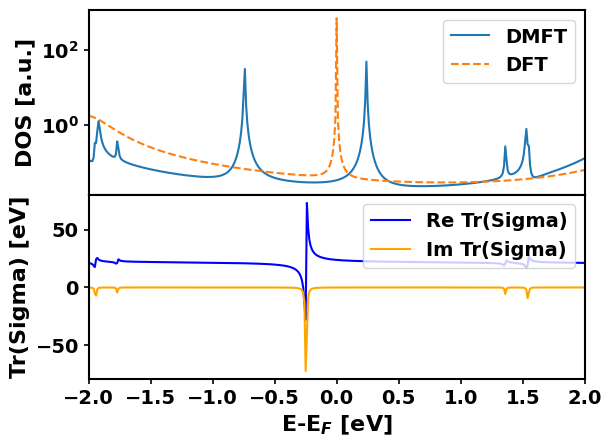

24:  |F(x)| = 1.17179; step 1
Iteration : 67
Occupation : 10.78730 Chemical potential : 0.21939 Error : 13.75344921 Relative Error : 0.02514142
Iteration : 68
Occupation : 10.78730 Chemical potential : 0.22074 Error : 10.58639479 Relative Error : 0.01933611
Iteration : 69
Occupation : 10.78730 Chemical potential : 0.22125 Error : 12.15913729 Relative Error : 0.02220158
Iteration : 70
Occupation : 10.78730 Chemical potential : 0.22135 Error : 12.79787735 Relative Error : 0.02336490
Iteration : 71
Occupation : 10.78730 Chemical potential : 0.22142 Error : 12.89140745 Relative Error : 0.02353539
Iteration : 72
Occupation : 10.78730 Chemical potential : 0.22146 Error : 12.92723153 Relative Error : 0.02360074
Iteration : 73
Occupation : 10.78730 Chemical potential : 0.22150 Error : 12.94540360 Relative Error : 0.02363390
Iteration : 74
Occupation : 10.78730 Chemical potential : 0.22412 Error : 15.43616226 Relative Error : 0.02821744


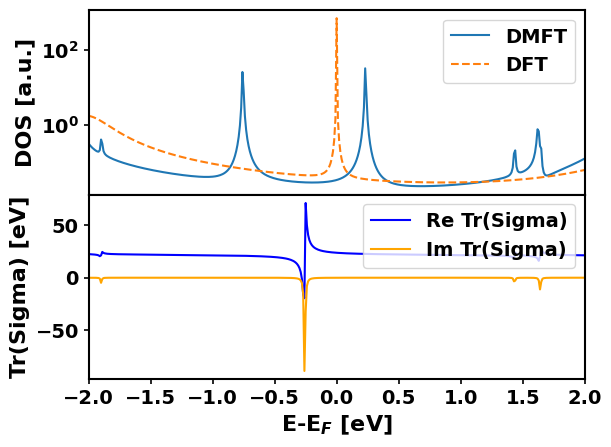

25:  |F(x)| = 1.799; step 1
Iteration : 75
Occupation : 10.78730 Chemical potential : 0.22700 Error : 9.94266690 Relative Error : 0.01835570


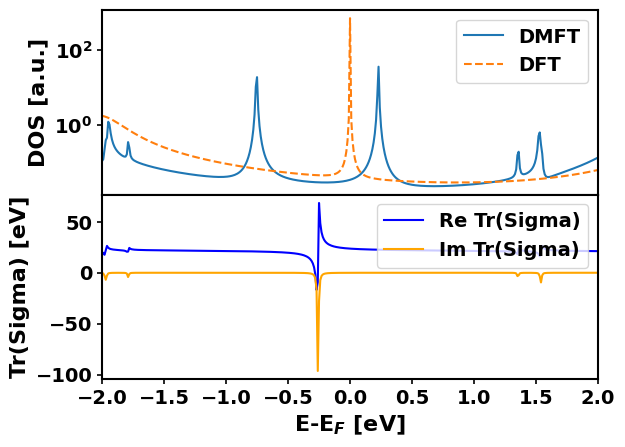

26:  |F(x)| = 1.16786; step 1
Iteration : 76
Occupation : 10.78730 Chemical potential : 0.23123 Error : 7.00874082 Relative Error : 0.01302030


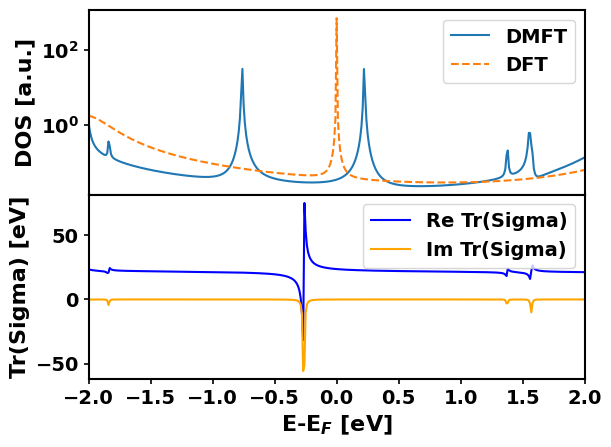

27:  |F(x)| = 0.828122; step 1
Iteration : 77
Occupation : 10.78730 Chemical potential : 0.23779 Error : 8.87217128 Relative Error : 0.01669311
Iteration : 78
Occupation : 10.78730 Chemical potential : 0.23957 Error : 9.37919939 Relative Error : 0.01749366
Iteration : 79
Occupation : 10.78730 Chemical potential : 0.23978 Error : 10.97365690 Relative Error : 0.02039471
Iteration : 80
Occupation : 10.78730 Chemical potential : 0.23972 Error : 11.08380456 Relative Error : 0.02059176
Iteration : 81
Occupation : 10.78730 Chemical potential : 0.23967 Error : 11.08130840 Relative Error : 0.02058630
Iteration : 82
Occupation : 10.78730 Chemical potential : 0.23963 Error : 11.07273800 Relative Error : 0.02057016
Iteration : 83
Occupation : 10.78730 Chemical potential : 0.23961 Error : 11.06257339 Relative Error : 0.02055122
Iteration : 84
Occupation : 10.78730 Chemical potential : 0.24322 Error : 10.05520916 Relative Error : 0.01891901


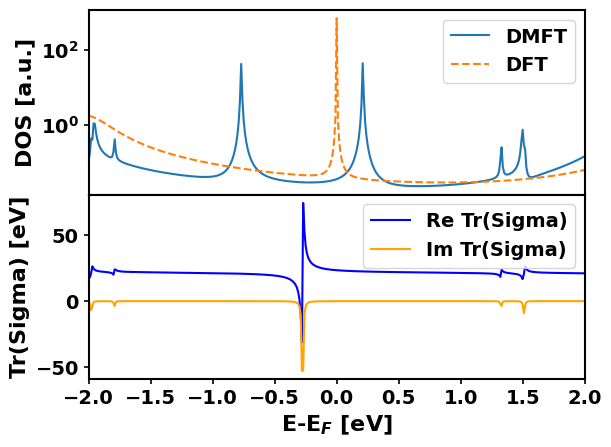

28:  |F(x)| = 1.20878; step 1
Iteration : 85
Occupation : 10.78730 Chemical potential : 0.24457 Error : 13.17977198 Relative Error : 0.02458721
Iteration : 86
Occupation : 10.78730 Chemical potential : 0.24627 Error : 9.39999798 Relative Error : 0.01764378


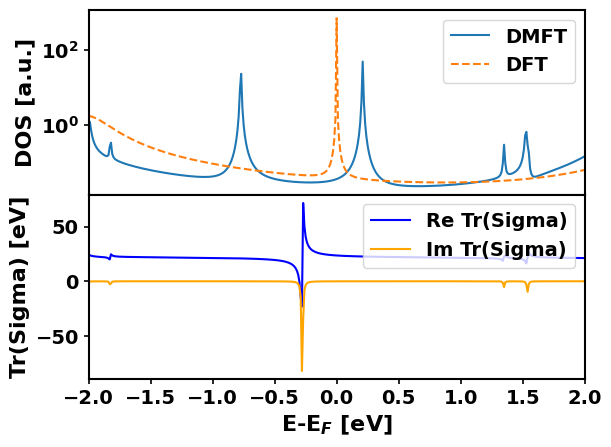

29:  |F(x)| = 1.1164; step 0.291029
Iteration : 87
Occupation : 10.78730 Chemical potential : 0.24983 Error : 7.44854009 Relative Error : 0.01410118


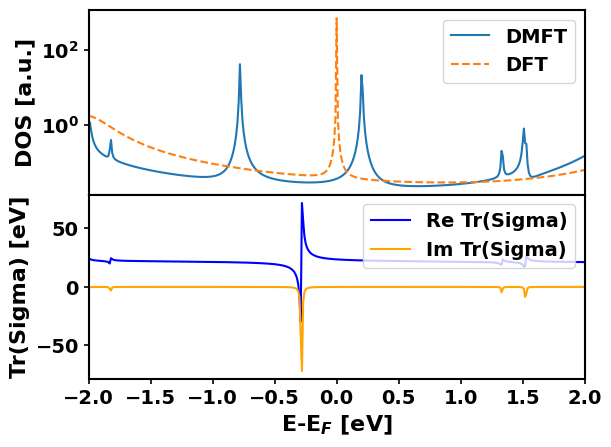

30:  |F(x)| = 0.86133; step 1
Iteration : 88
Occupation : 10.78730 Chemical potential : 0.25863 Error : 10.52366395 Relative Error : 0.02014486
Iteration : 89
Occupation : 10.78730 Chemical potential : 0.25965 Error : 8.98553302 Relative Error : 0.01706075
Iteration : 90
Occupation : 10.78730 Chemical potential : 0.25889 Error : 10.61070089 Relative Error : 0.02009632
Iteration : 91
Occupation : 10.78730 Chemical potential : 0.25816 Error : 10.66090657 Relative Error : 0.02018356
Iteration : 92
Occupation : 10.78730 Chemical potential : 0.25767 Error : 10.49963922 Relative Error : 0.01987760
Iteration : 93
Occupation : 10.78730 Chemical potential : 0.25735 Error : 10.38107028 Relative Error : 0.01965296
Iteration : 94
Occupation : 10.78730 Chemical potential : 0.25714 Error : 10.29864615 Relative Error : 0.01949687
Iteration : 95
Occupation : 10.78730 Chemical potential : 0.26346 Error : 11.49962681 Relative Error : 0.02201309


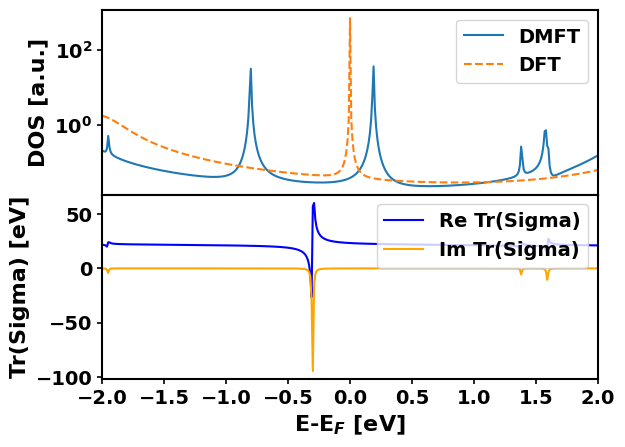

31:  |F(x)| = 1.31101; step 1
Iteration : 96
Occupation : 10.78730 Chemical potential : 0.26619 Error : 9.42286886 Relative Error : 0.01806837


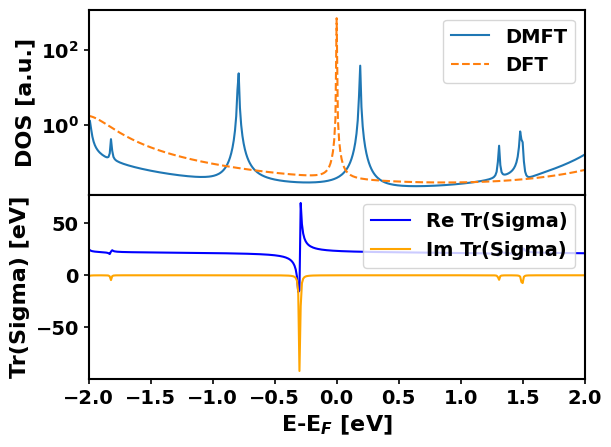

32:  |F(x)| = 1.11169; step 1
Iteration : 97
Occupation : 10.78730 Chemical potential : 0.27099 Error : 5.52180194 Relative Error : 0.01066180


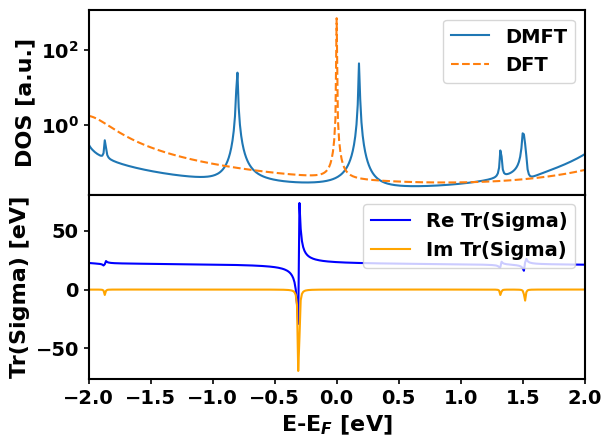

33:  |F(x)| = 0.661818; step 1
Iteration : 98
Occupation : 10.78730 Chemical potential : 0.27841 Error : 6.48063190 Relative Error : 0.01265120
Iteration : 99
Occupation : 10.78730 Chemical potential : 0.28057 Error : 7.84199953 Relative Error : 0.01520250
Iteration : 100
Occupation : 10.78730 Chemical potential : 0.28063 Error : 9.38742002 Relative Error : 0.01813246
Iteration : 101
Occupation : 10.78730 Chemical potential : 0.28060 Error : 9.56254144 Relative Error : 0.01846479
Iteration : 102
Occupation : 10.78730 Chemical potential : 0.28052 Error : 9.53730125 Relative Error : 0.01841538
Iteration : 103
Occupation : 10.78730 Chemical potential : 0.28048 Error : 9.52424505 Relative Error : 0.01839000
Iteration : 104
Occupation : 10.78730 Chemical potential : 0.28045 Error : 9.51352672 Relative Error : 0.01836926
Iteration : 105
Occupation : 10.78730 Chemical potential : 0.28043 Error : 9.50587729 Relative Error : 0.01835448
Iteration : 106
Occupation : 10.78730 Chemical potential : 

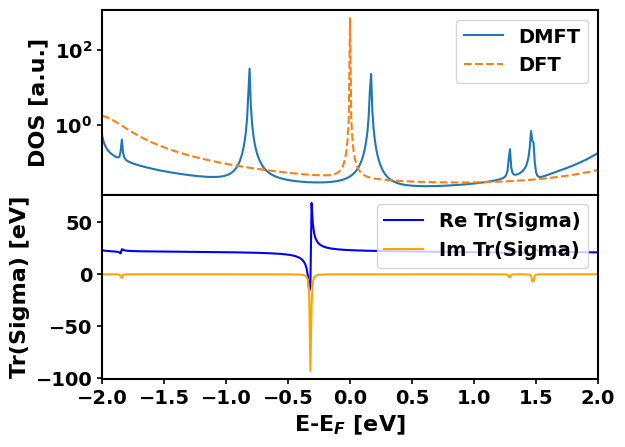

34:  |F(x)| = 0.968032; step 1
Iteration : 107
Occupation : 10.78730 Chemical potential : 0.28328 Error : 17.48631909 Relative Error : 0.03365887
Iteration : 108
Occupation : 10.78730 Chemical potential : 0.28612 Error : 7.56932657 Relative Error : 0.01475732


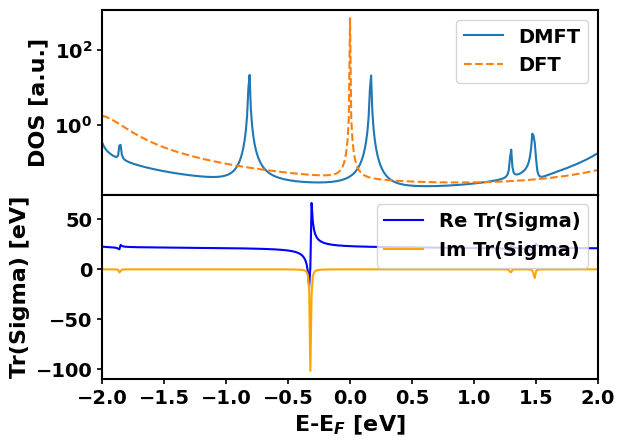

35:  |F(x)| = 0.953039; step 0.0959589
Iteration : 109


KeyboardInterrupt: 

In [49]:
dmft.it = 0
dmft.solve(dmft.delta, alpha=1.0, callback=callback)

In [17]:
_Sigma = lambda z: -double_counting.diagonal()[:, None] - gfloc_with_dccorrection.mu + gfloc_with_dccorrection.Sigma(z)[idx_inv]

dmft_sigma_file = f"{data_folder}/dmft_U0_sigma.npy"
save_sigma(_Sigma(z_ret), dmft_sigma_file,nspin)